In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load the data
df = pd.read_csv('../data/train_enc.csv')

In [5]:
# Split the data into training and validation sets
train, validation = train_test_split(df, test_size=0.2, random_state=200, shuffle=True)

print(train.shape)
print(validation.shape)

(1168, 264)
(292, 264)


In [6]:
# split the columns into features and target; ie x y split
target = 'SalePrice'
X_train = train.drop(target, axis=1)
y_train = train[target]

X_validation = validation.drop(target, axis=1)
y_validation = validation[target]

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((1168, 263), (1168,), (292, 263), (292,))

## Grid Search for Hyperparameter Tuning

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to try
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100],
    'max_depth': [5, 7, 9, 11, 13, 15]
}

# Create the model
rfr_model = RandomForestRegressor()

# Create the grid search object
grid_search = GridSearchCV(estimator=rfr_model, param_grid=param_grid, cv=5, scoring='r2', return_train_score=True, verbose=True, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparameters = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

print(f'Best hyperparameters: {best_hyperparameters}, Best r2 score: {best_score}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters: {'max_depth': 15, 'n_estimators': 80}, Best r2 score: 0.8445337742352728


##### Best hyperparameters: {'max_depth': 15, 'n_estimators': 100}, Best r2 score: 0.8465457631496612

## Visualizing Grid Search Results in a Heatmap

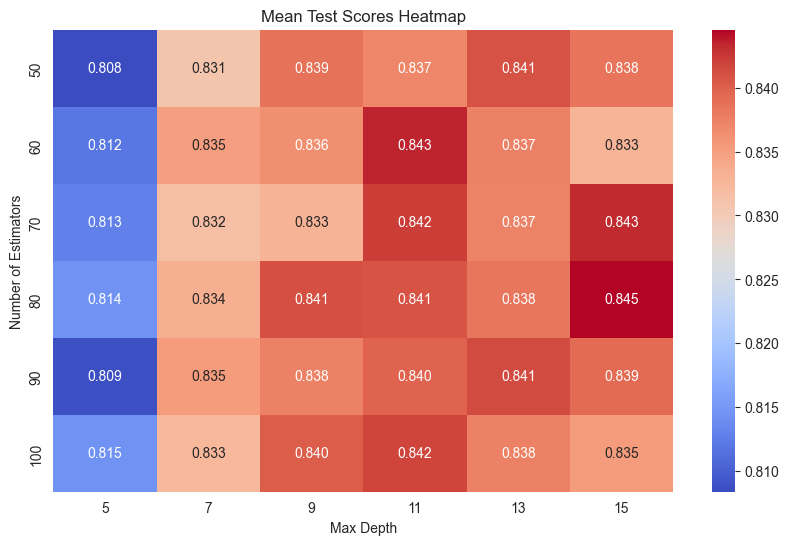

In [33]:
# Extract results from grid search
results = grid_search.cv_results_

# Extract relevant information
# params = results['params']
# mean_test_score = results['mean_test_score']
# std_test_score = results['std_test_score']

# Create DataFrame for visualization
df_results = pd.DataFrame(results['params'])
df_results['mean_test_score'] = results['mean_test_score']
df_results['std_test_score'] = results['std_test_score']

# Reshape the data for heatmap
heatmap_data = df_results.pivot(index='n_estimators', columns='max_depth', values='mean_test_score')

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm")
plt.title('Mean Test Scores Heatmap')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.show()

##### Grid Search Results -> Best hyperparameters: {'max_depth': 10, 'n_estimators': 150}, Best r2 score: 0.8635347858325373. Different from manual search.

Text(0, 0.5, 'Mean Test Score')

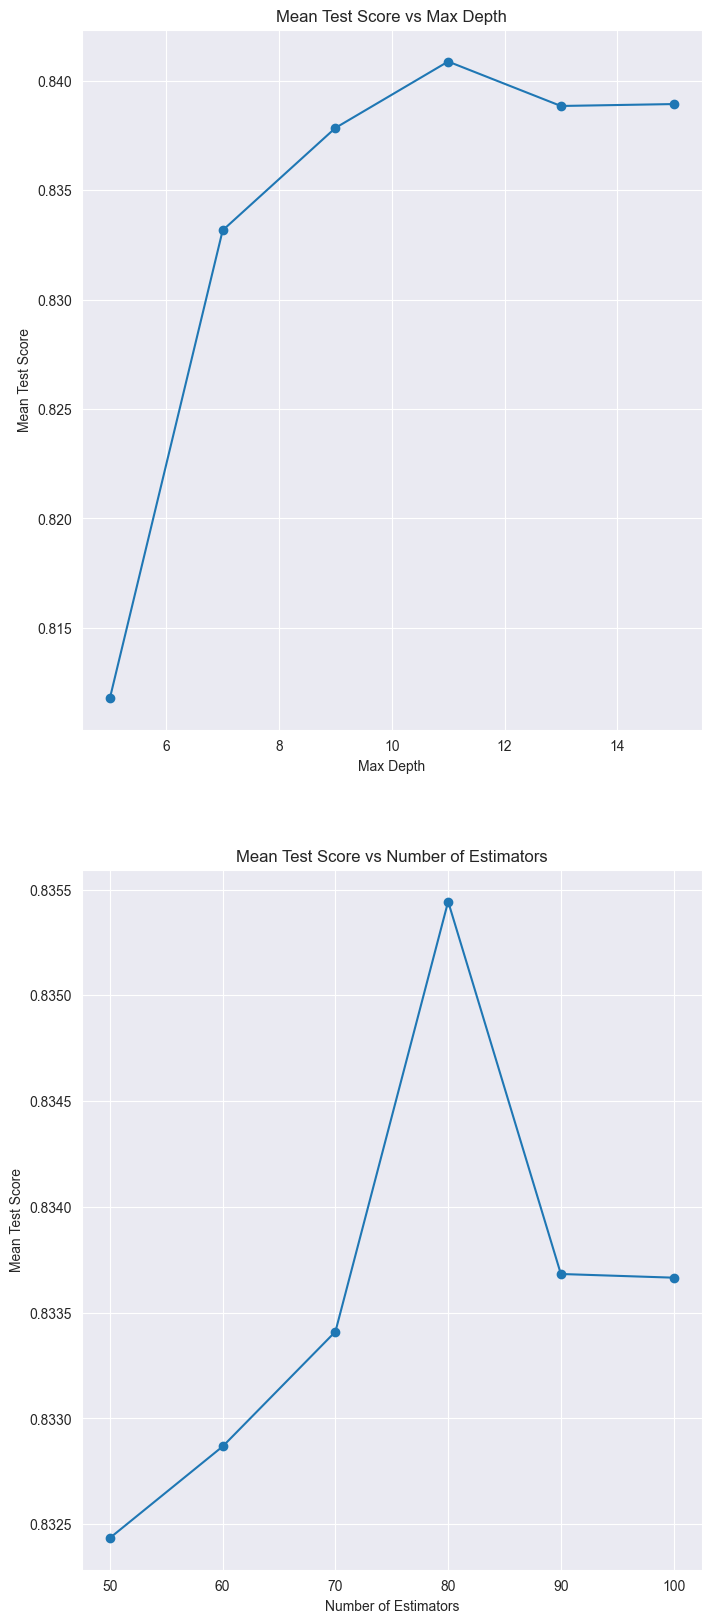

In [34]:
# drop duplicates from the results
val_scores = results['mean_test_score'].reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']))

mean_val_scores_ne = val_scores.mean(axis=0)
mean_val_scores_md = val_scores.mean(axis=1)

# Create line plots of r2 score against max depth and number of estimators
fig, axs = plt.subplots(2, 1, figsize=(8, 20), facecolor='w', edgecolor='k')
axs[0].plot(param_grid['max_depth'], mean_val_scores_md, marker='o')
axs[0].set_title('Mean Test Score vs Max Depth')
axs[0].set_xlabel('Max Depth')
axs[0].set_ylabel('Mean Test Score')

axs[1].plot(param_grid['n_estimators'], mean_val_scores_ne, marker='o')
axs[1].set_title('Mean Test Score vs Number of Estimators')
axs[1].set_xlabel('Number of Estimators')
axs[1].set_ylabel('Mean Test Score')

In [ ]:
rfr_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_validation = rfr_model.predict(X_validation)

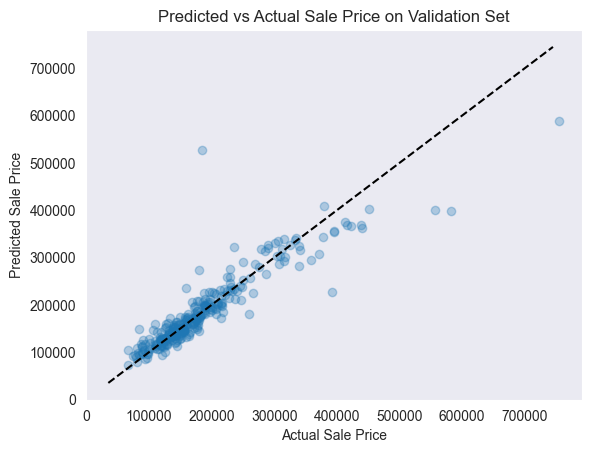

In [43]:
import numpy as np
# Plotting
plt.scatter(y_validation, y_pred_validation, alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs Actual Sale Price on Validation Set')
plt.grid(False)
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_validation = rfr_model.predict(X_validation)
y_pred_log = np.log(y_pred_validation)
y_actual_log = np.log(y_validation)
rmse = np.sqrt(mean_squared_error(y_actual_log, y_pred_log))
rmse

0.1449457300507894

Running the model with the best hyperparameters multiple times to check for consistency.

In [ ]:
# Create the model with the best hyperparameters
rfr_model = RandomForestRegressor(n_estimators=150, max_depth=5)

#run the model 20 times and plot the r2 scores
r2_scores = []
for i in range(20):
    train, validation = train_test_split(df, test_size=0.2, random_state=i, shuffle=True)
    target = 'SalePrice'
    X_train = train.drop(target, axis=1)
    y_train = train[target]
    
    X_validation = validation.drop(target, axis=1)
    y_validation = validation[target]
    
    # Fit the model
    rfr_model.fit(X_train, y_train)

    # Make predictions
    validation_predictions = rfr_model.predict(X_validation)

    # Calculate and print the r squared error
    score = r2_score(y_validation, validation_predictions)
    print(score)
    r2_scores.append(score)

NameError: name 'r2_scores' is not defined

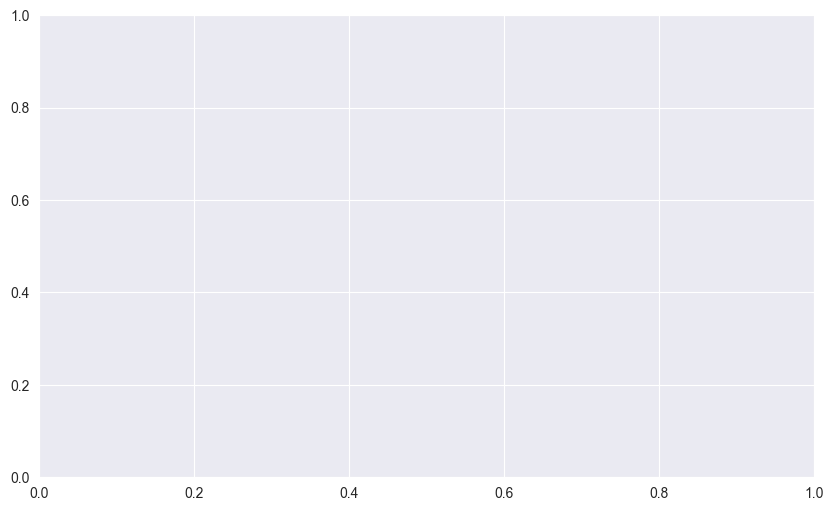

In [9]:
 # Plot the r2 scores to show consistency
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(20), y=r2_scores, ax=ax)
ax.set_title('R2 Score Lineplot')
ax.set_ylim(0.65, 0.95)
ax.set_xticks(range(0, 21, 2))
plt.show()

##### The r2 scores are consistent, except for some outliers. This means the hyperparameters are stable and the model is consistent.

## Submission to Kaggle

In [ ]:
# Record predictions for the test set
test = pd.read_csv('../data/test_enc.csv')
test_predictions = rfr_model.predict(test)

# add the Id column to the predictions
df_test = pd.read_csv('../data/test.csv')
test_predictions = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': test_predictions})

# Save the predictions to a CSV file
test_predictions.to_csv('../rfr_test_predictions.csv', index=False)

test_predictions